#### Script to establish/print out WRF model domain specs.

James Ruppert\
jruppert@ou.edu\
12/22/23

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from wrf import getvar, disable_xarray, latlon_coords, extract_global_attrs
from IPython.display import Image
import subprocess
import sys

In [2]:
wrf_file = "WRF/run/wrfinput_d02"#wrfout_d01_2021-08-27_00:00:00"
ncfile = Dataset(wrf_file)
# enable_xarray()

dx = extract_global_attrs(ncfile, "DX")
u10 = getvar(ncfile, "U10") # K
# tmpk = getvar(ncfile, "tk") # K
# pres = getvar(ncfile, "pressure")*1e2 # hPa --> Pa
# qv = getvar(ncfile, "QVAPOR") # kg/kg
hght = getvar(ncfile, "zstag", units='m')[:,0,0] # m
# lats, lons = latlon_coords(u10)

ncfile.close()

### N-Node tests

Tested by running a 1.5-hr (wall clock) job

Model time achieved:

runN10
2.7

runN12
3.0166666666666666

runN18
3.9166666666666665

Core hours required:

runN10
1920.0

runN12
2304.0

runN18
3456.0



Text(0, 0.5, 'Core hours (red)')

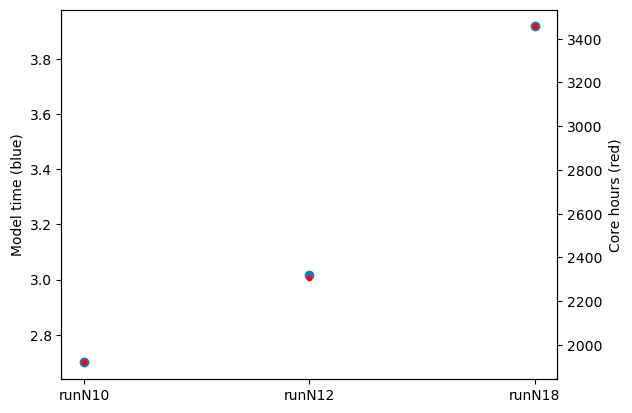

In [54]:
print("Tested by running a 1.5-hr (wall clock) job")
print()

tests = ["runN10","runN12","runN18"]

print("Model time achieved:")
print()
times_sav=[]
for itest in tests:
    print(itest)
    process = subprocess.Popen(['tail -n 5 WRF/'+itest+'/rslout/rsl.out.0000'],shell=True,
        stdout=subprocess.PIPE,universal_newlines=True)
    for iline in range(4):
        output = process.stdout.readline()
    line = output.strip()
    time_string = line.split()[6]
    time_hrs = float(time_string[-8:-6]) + float(time_string[-5:-3])/60
    times_sav.append(time_hrs)
    print(time_hrs)
    print()

print("Core hours required:")
print()
core_hours = np.array([10., 12, 18])*128*1.5
for itest in range(3):
    print(tests[itest])
    print(core_hours[itest])
    print()

fig, ax1 = plt.subplots()
ax1.scatter(tests,times_sav)
ax1.set_ylabel("Model time (blue)")
ax2 = ax1.twinx()
ax2.scatter(tests,core_hours, s=10, c='red')
ax2.set_ylabel("Core hours (red)")

In [21]:
line.split()

['Timing',
 'for',
 'main',
 '(dt=',
 '3.08):',
 'time',
 '2023-08-12_03:55:13',
 'on',
 'domain',
 '2:',
 '0.61271',
 'elapsed',
 'seconds']

### Horizontal domain specs

NX = 1500
NY = 1500
DX (km) = 1.0
The domain:


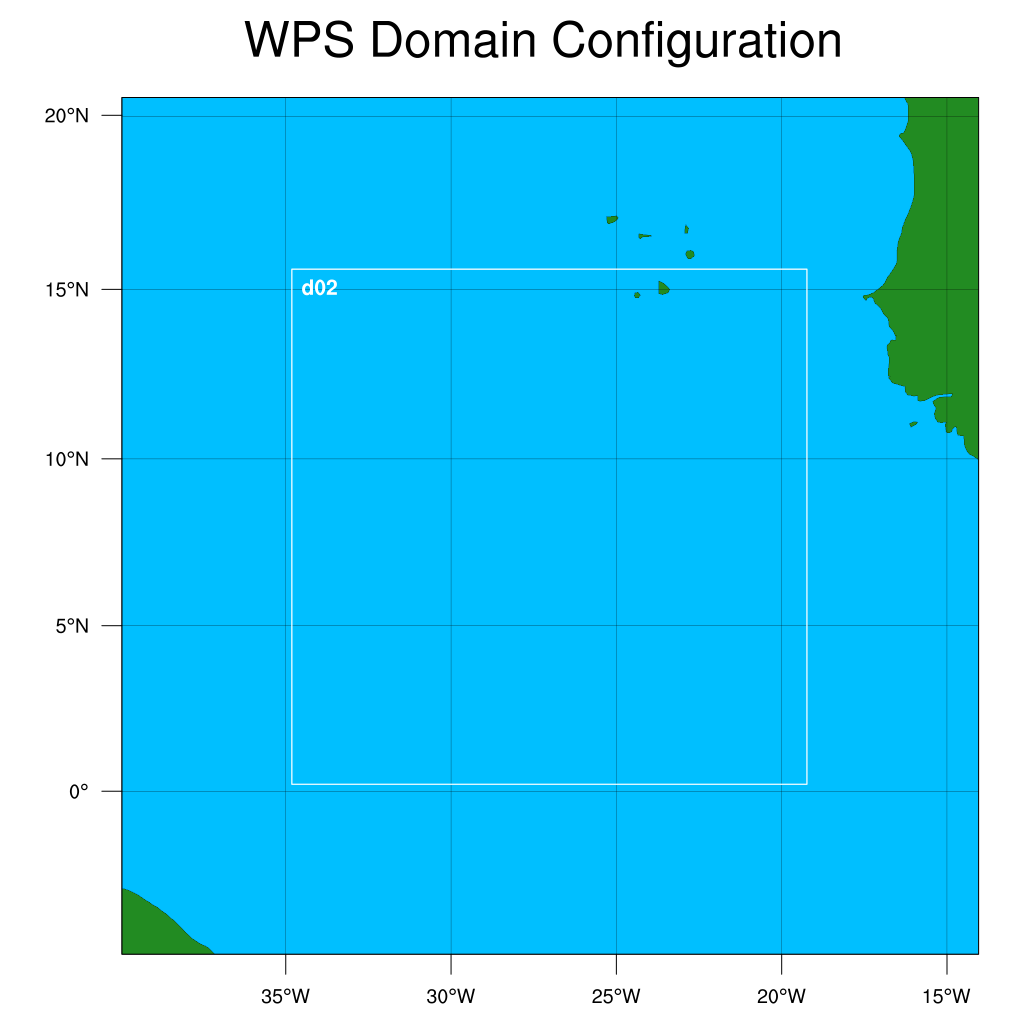

In [3]:
ny, nx = u10.shape
print("NX =",nx)
print("NY =",ny)
print("DX (km) =",dx['DX']/1e3)
print("The domain:")
Image(filename='WPS/wps_show_dom.png') 

### Vertical grid specs

Max height of staggered vertical grid (km):  29.75


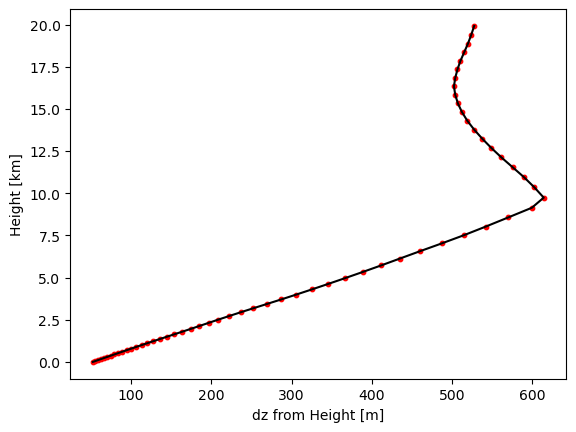

In [4]:
# Plot WRF dz vs. height
nz = hght.size-1
dz = np.zeros(nz)
for iz in range(nz):
    dz[iz] = hght[iz+1]-hght[iz]
# plt.plot(dz,hght[:nz]*1e-3)
ztop = hght.data.max()*1e-3
print("Max height of staggered vertical grid (km): ",np.round(ztop,2))
ztop_plot = np.min(np.where(hght > 20e3))
plt.plot(dz[:ztop_plot],hght[:ztop_plot]*1e-3, 'k')
plt.xlabel("dz from Height [m]")
plt.ylabel("Height [km]")
plt.scatter(dz[:ztop_plot],hght[:ztop_plot]*1e-3, s=10, c='red')

### The below blocks are for testing the code taken from WRF's built-in stretched vertical grid function

In [5]:
# WRF Stretched vertical levels subroutine
# specifically: SUBROUTINE levels inside of WRF/dyn_em/module_initialize_real.F

def get_dz(nlev, ptop, dzmax, dzbot, dzstretch_s, dzstretch_u):

    verbose=False
    # verbose=True

    r_d=287
    g=9.81

    print("nlev = ", nlev)
    # print("ptop = ", ptop)
    # print("dzmax = ", dzmax)
    # print("dzbot = ", dzbot)
    print("dzstretch_s = ", dzstretch_s)
    print("dzstretch_u = ", dzstretch_u)
    print()

    # real, dimension(nlev) :: zup, pup
    zup = np.zeros(nlev)
    pup = np.zeros(nlev)
    eta = np.zeros(nlev+1)
    dz_sav = np.zeros(nlev)
    # real :: tt, a
    # real :: ztop, dz, dztest, zscale
    # integer :: isave, i

    tt=290. # isothermal temperature used for z/log p relation - tt=290 fits dzbot
    ztop=r_d*tt/g*np.log(1.e5/ptop)
    if verbose:
        print(ztop,nlev)
    zscale=r_d*tt/g
    dz=dzbot
    dz_sav[0]=dz
    zup[1]=dz
    pup[1]=1.e5*np.exp(-g*zup[1]/r_d/tt)
    eta[0]=1.0
    eta[1]=(pup[1]-ptop)/(1.e5-ptop)
    if verbose:
        print(1,dz,zup[1],eta[1])
    isave=1
    for i in range(1,nlev-1):
        a=dzstretch_u+(dzstretch_s-dzstretch_u)*np.max([(dzmax*0.5-dz)/(dzmax*0.5), 0.])
        dz=a*dz
        # print(dz)
        dztest=(ztop-zup[isave])/(nlev-isave)
        if(dztest < dz):
            continue
        isave=i+1
        zup[i+1]=zup[i]+dz
        pup[i+1]=1.e5*np.exp(-g*zup[i+1]/r_d/tt)
        eta[i+1]=(pup[i+1]-ptop)/(1.e5-ptop)
        dz_sav[i]=dz
        if verbose:
            print(i+1,dz,zup[i+1],eta[i+1],a)
        if i == nlev-1:
            print("ERROR #1 !!")
            sys.exit()
            # CALL wrf_debug ( 0, 'You need one of four things:' )
            # CALL wrf_debug ( 0, '1) More eta levels: e_vert' )
            # CALL wrf_debug ( 0, '2) A lower p_top: p_top_requested')
            # CALL wrf_debug ( 0, '3) Increase the lowest eta thickness: dzbot')
            # CALL wrf_debug ( 0, '4) Increase the stretching factor: dzstretch_s or dzstretch_u')
            # CALL wrf_debug ( 0, 'All are namelist options')
            # CALL wrf_error_fatal ( 'not enough eta levels to reach p_top')
    if verbose:
        print()
        print(ztop,zup[isave],nlev,isave)
        print()
    dz=(ztop-zup[isave])/(nlev-isave)
    dz_sav[isave-1]=dz
    if dz > 1.5*dzmax:       # isothermal temp 1.5 times stratosphere temp
        print("ERROR #2 !!")
        sys.exit()
    #         # CALL wrf_debug ( 0, 'Warning: Upper levels may be too thick' )
    #         # CALL wrf_debug ( 0, 'You need one of five things:' )
    #         # CALL wrf_debug ( 0, '1) More eta levels: e_vert' )
    #         # CALL wrf_debug ( 0, '2) A lower p_top: p_top_requested')
    #         # CALL wrf_debug ( 0, '3) Increase the lowest eta thickness: dzbot')
    #         # CALL wrf_debug ( 0, '4) Increase the stretching factor: dzstretch_s or dzstretch_u')
    #         # CALL wrf_debug ( 0, '5) Increase the maximum allowed thickness: max_dz')
    #         # CALL wrf_debug ( 0, 'All are namelist options')
    #         # CALL wrf_error_fatal ( 'Upper levels may be too thick')
    for i in range(isave,nlev-1):
        zup[i+1]=zup[i]+dz
        pup[i+1]=1.e5*np.exp(-g*zup[i+1]/r_d/tt)
        eta[i+1]=(pup[i+1]-ptop)/(1.e5-ptop)
        dz_sav[i]=dz
        if verbose:
            print(i+1,dz,zup[i+1],eta[i+1])
    eta[nlev] = 0.
    # print(1000, eta)
    # plt.scatter(eta[0:nlev],zup)
    print(ztop)

    return dz_sav, zup

nlev =  80
dzstretch_s =  1.06
dzstretch_u =  1.07

37524.33143810683


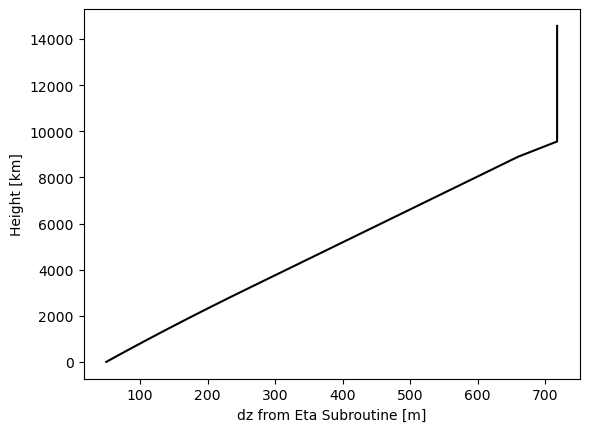

In [6]:
# Call stretched levels subroutine and plot it

inlev=(75,85,95)
nlev=80           # number of levels
# iptop=(10*1e2,15*1e2,20*1e2)
ptop=12*1e2       # top pressure (Pa)
# idzmax=(480,600,700,800,1000)
dzmax=500         # max dz
dzbot=50          # bottom dz
# idzs=(1.0, 1.02, 1.05, 1.1, 1.2, 1.3)
dzstretch_s = 1.06 # lower stretch factor
idzu=(1.06, 1.07, 1.08, 1.1, 1.2)
dzstretch_u = 1.07 # upper stretch factor

ndims=np.size(idzu)

for idim in range(1):
# for idim in range(ndims):

    # nlev=inlev[idim]
    # dzmax=idzmax[idim]
    # dzstretch_s = idzs[idim]
    # dzstretch_u = idzu[idim]
    # ptop=iptop[idim]

    dz_sav, zup = get_dz(nlev, ptop, dzmax, dzbot, dzstretch_s, dzstretch_u)

    iztrop = np.min(np.where(zup > 15e3))
    if idim == 0:
        line='k'
    elif idim == 1:
        line='g'
    elif idim == 2:
        line='b'
    elif idim == 3:
        line='r'
    elif idim == 4:
        line='m'
    plt.plot(dz_sav[0:iztrop],zup[0:iztrop], line)
    plt.xlabel("dz from Eta Subroutine [m]")
    plt.ylabel("Height [km]")